# Setup imports 

In [20]:
%matplotlib inline

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sys import path
import pathlib

path.append('./OASIS')
print(pathlib.Path().absolute())


from oasis.functions import gen_data, gen_sinusoidal_data, deconvolve, estimate_parameters
from oasis.plotting import simpleaxis
#from oasis.oasis_methods import oasisAR1, oasisAR2



/Users/nicolemoiseyev/Developer/improv-sketches/stimdistributions


# Import data 

Stim shape:  (2878, 3)
Response shape:  (639, 2878)
Frames:  2878
Neurons:  639
Number of stim:  20


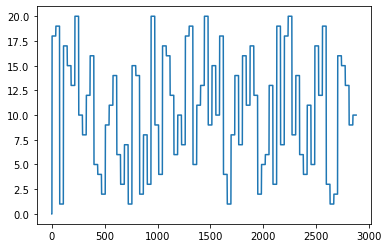

In [26]:
path.append('..')


# Import data

# stim - data on which stimulus was on for each frame
stim = np.loadtxt("data/stim_data.txt") 
# ests - raw Ca++ imaginig data
data = np.loadtxt("data/raw_C.txt")

print("Stim shape: ", stim.shape)
print("Response shape: ",ests.shape)

num_frames = stim.shape[0]
num_neurons = ests.shape[0]

print("Frames: ", num_frames)
print("Neurons: ", num_neurons)

stim = stim.astype(int)

num_stim = np.max(stim[:,0])
print("Number of stim: ", num_stim)

# Double checking that each stim has 4 "on" windows
fig, ax = plt.subplots()
plt.plot(stim[:,0])



# Create windows where each stim is on

In [55]:
# Create windows where each stim is on

stimStart = {} # key: stim, value: list of frames stim was turned on
stimEnd = {} # key: stim, value: list of frames stim was turned off

framesStimOn = [] # frames when a stim was turned on
framesStimOff = [] # frames when a stim was turned off

stimFrames = {} # key: frame, value: stim on

num_on_windows = 0 # number of windows (during which any stim was on or no stim were on)
num_off_windows = 0 # number of windows no stim was on
for s in range(0,num_stim+1):
    stimStart[s] = []
    stimEnd[s] = []

# For each stim, construct array of indices when frame was turned on (start) and off (end)
# Also construct similar array for start and start of "off" windows, i.e. no stim on
lastOn = False
lastOff = True
for f in range(num_frames):
    curr_stim = stim[f,0] 
    
    # assign this frame to a stim
    # if a stim is on, it is that stim
    # if stim is off, consider the stim to be the last stim
    stimFrames[f] = curr_stim 

    if ((stim[f, 1] < -18 or stim[f,1] > 18)):
        if (lastOff): # Stim was just turned on this frame
            num_on_windows += 1 # Increment number of windows
            framesStimOn.append(f) # Add this datapoint to list of frames when a stim was turned on
            stimStart[curr_stim].append(f)
            stimEnd[0].append(f) # off window just ended
            num_off_windows += 1 # Incremement number of off windows (since we set them based on ends)
            lastOn = True
            lastOff = False
            

    elif (stim[f, 1] == 0):
        if (lastOn): # Stim was just turned off this frame
            stimEnd[curr_stim].append(f)
            framesStimOff.append(f)
            stimStart[0].append(f) # off window just started
            lastOn = False
            lastOff = True

            
# total windows
num_windows = num_on_windows + num_off_windows

windowStim = {} # key: window ID, value: stim on in window with that window ID (**not chronological)


curr_window = 0
for s in range(0, num_stim+1):
    for w in range(len(stimStart[s])):
        start = stimStart[s][w]
        try:
            end = stimEnd[s][w]
        except IndexError: # more "end" values than "start" values; "end" must be the last frame in the dataset
            end = num_frames
        windowStim[curr_window] = s
        curr_window += 1
        
framesStimOn = np.array(framesStimOn)
framesStimOff = np.array(framesStimOff)

print("Created {} windows where a stimulus was on".format(num_on_windows))
print("Created {} windows where all stimulus were off".format(num_off_windows))

Created 80 windows where a stimulus was on
Created 80 windows where all stimulus were off


In [56]:
def plotStimWindows(onLines, offLines):
    for i in range(onLines.size):
        on = onLines[i]
        try:
            off = offLines[i]
        except IndexError:
            off = end
        plt.axvspan(on, off, 0, 1, alpha = 0.1, color='green')

def plot_trace(neuron,penalty=0,start=0,end=-1,stim=True):
    
    def plotStimWindows(onLines, offLines):
        for i in range(onLines.size):
            on = onLines[i]
            try:
                off = offLines[i]
            except IndexError:
                off = end
            plt.axvspan(on, off, 0, 1, alpha = 0.1, color='green')
    
    c, s, b, g, lam = deconv_neuron(neuron,penalty=penalty)
    
    if (end == -1):
        end = c.shape[0]
    
    plt.figure(figsize=(20,8))
    plt.subplot(211)
    denoised = b + c
    plt.plot(denoised, lw=2, label='denoised')
    plt.title("Neuron {}".format(neuron))
    # Plot data
    plt.plot(data[neuron], label='data', zorder=-12, c='y')
    
    if (stim):
        # plot lines for stim
        plotStimWindows(framesStimOn,framesStimOff)

            
    # Plot baseline dotted line
    plt.plot([0,data.shape[1]], [baselines[neuron], baselines[neuron]], "b--")
    
    plt.legend(ncol=3, frameon=False, loc=(.02,.85))
    simpleaxis(plt.gca())
    plt.xlim(start,end)


    plt.subplot(212)
    plt.plot(s, lw=2, label='deconvolved', c='g')
    if (stim):
        # plot lines for stim
        plotStimWindows(framesStimOn,framesStimOff)
            
    plt.xlim(start,end)
    plt.legend(ncol=3, frameon=False, loc=(.02,.85));  
    
    simpleaxis(plt.gca())
    #print("Correlation of deconvolved activity  with ground truth ('spikes') : %.4f" % np.corrcoef(s,true_s)[0,1])
    #print("Correlation of denoised fluorescence with ground truth ('calcium'): %.4f" % np.corrcoef(c,true_c)[0,1])

# Load raw fluorescence data

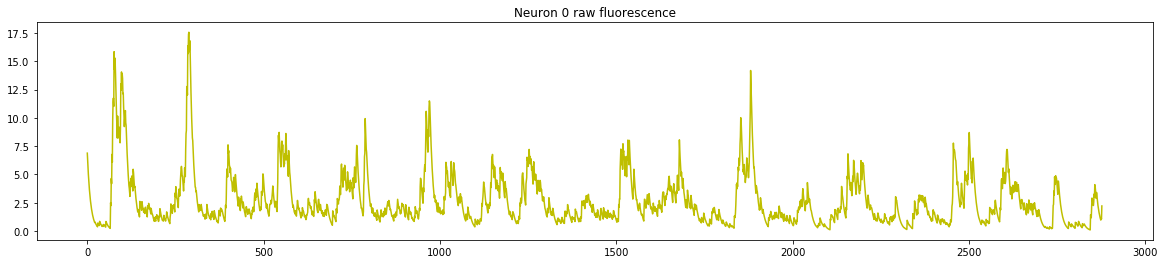

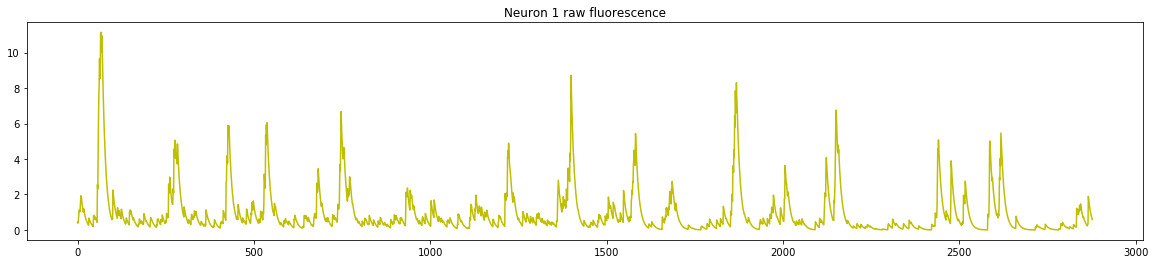

In [59]:
def plot_raw(neuron): 
    true_b = 2
    plt.figure(figsize=(20,4))
    plt.title("Neuron {} raw fluorescence".format(neuron))
    plt.plot(data[neuron], c='y');
    
plot_raw(0)
plot_raw(1)


# Deconvolve 

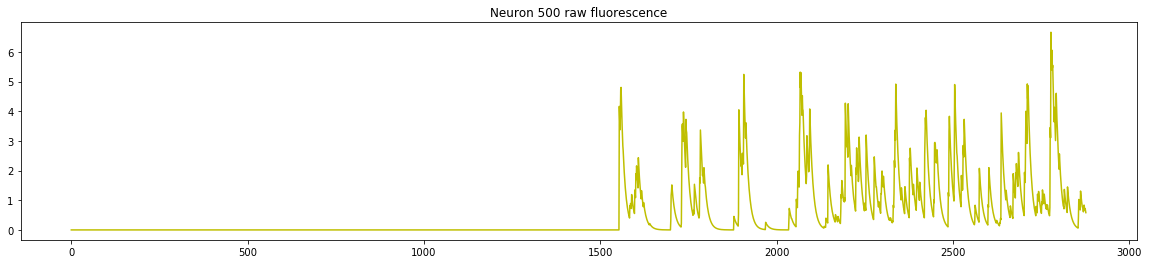

In [60]:
def deconv_neuron(neuron,penalty):
    return deconvolve(data[neuron],penalty=penalty)



#for neuron in range(0,5):
   # c,s,b,g,lam = deconv_neuron(neuron,penalty=1)
   # print("Neuron {} baseline: {}".format(neuron, b))
   # plot_raw(neuron)
    
plot_raw(500)



#%time c, s, b, g, lam = deconv_neuron(2)

# Calculate baselines and epsilons for all neurons in the dataset

In [61]:
baselines = np.zeros(data.shape[0])

epsilons = np.zeros_like(data)

for neuron in range(0, data.shape[0]):
    c,s,b,g,lam = deconv_neuron(neuron, penalty=1)
    epsilons[neuron] = data[neuron] - c
    baselines[neuron] = b
    
    
print("\n\nAverage baseline: {}".format(np.mean(baselines)))

print(np.mean(epsilons[0]))



Average baseline: 0.05872250875659821
0.11054831142710382


# Plot results
We do not have the ground truth data

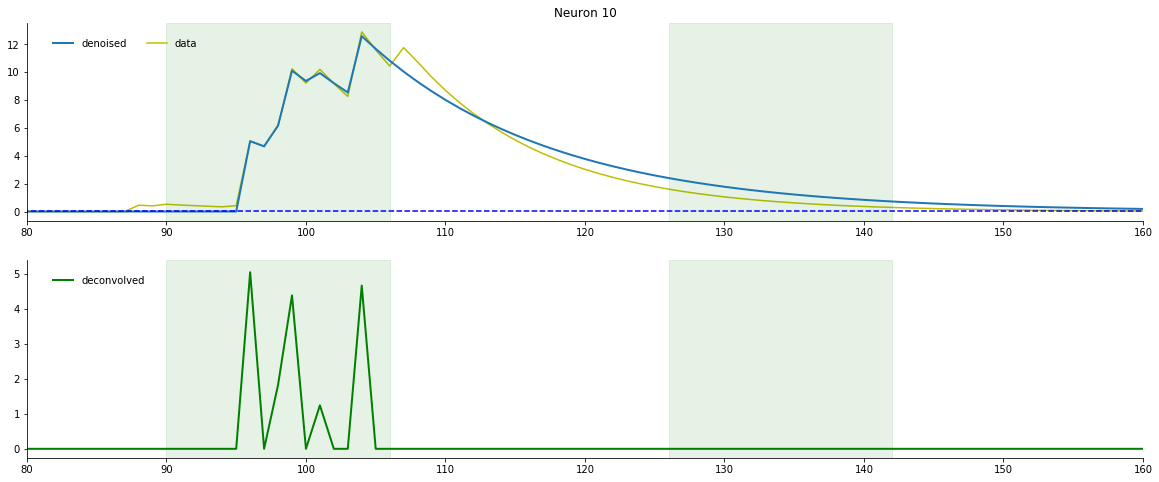

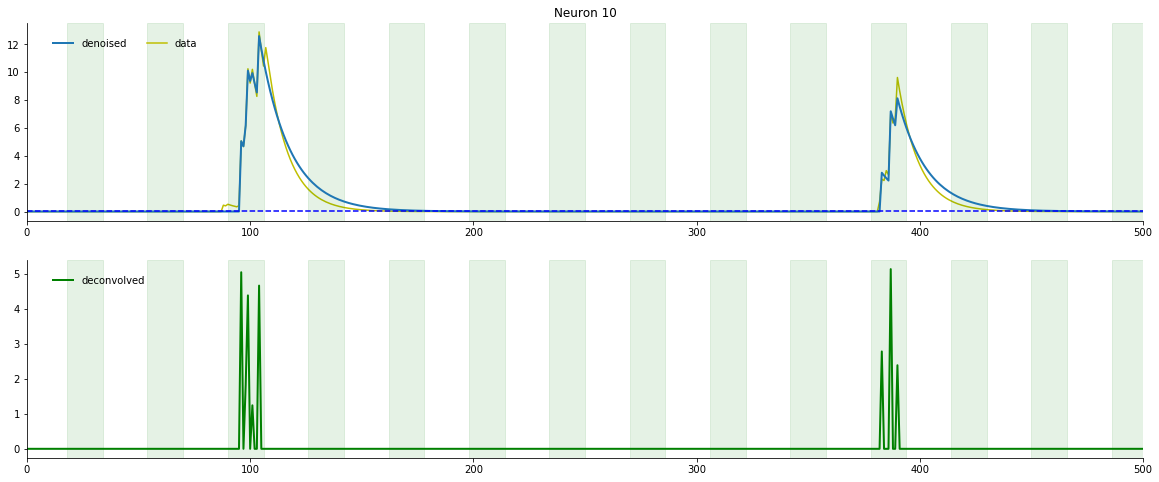

In [62]:

plot_trace(10,start=80,end=160)
plot_trace(10,start=0,end=500)



#plot_trace(200, groundtruth=False)
#plot_trace(500,groundtruth=False)

In [67]:
def calcOnStimLags(neuron):
    
    c,s,b,g,lam = deconv_neuron(neuron, penalty=1)
    
    threshold = 1 # threshold for considering a response to be a spike
    
    onFrames = [] # all frames this neuron first became active for a window
    onStim = set() # stims this neuron was active for
    lag = []
    length = []

    for i in range(len(framesStimOn)-1):
        currStimInd = framesStimOn[i]
        nextStimInd = framesStimOn[i+1]
        for f in range(currStimInd, nextStimInd):
            if (s[f] > threshold):
                onFrames.append(f)
                onStim.add(stimFrames[f])
                lag.append(f - currStimInd)
                
                lastIndOn = f
                for end in range(f,nextStimInd):
                    if (s[end] > threshold):
                        lastIndOn = end
                length.append(lastIndOn - f)
                break
    lagStd = np.std(lag)
    lag = np.mean(lag)
    length = np.mean(length)
    return onStim, lag, lagStd, length

calcOnStimLags(10)
calcOnStimLags(15)




({1, 4, 5, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20},
 12.342857142857143,
 9.42926404382459,
 10.2)

In [71]:
from scipy.stats import norm


# Compute all lags, setting threshold to 2 for now
allLags = []

# Compute number of stim the neuron is active toward
stimCounts = []

hyperNeurons = []

# Compute lengths of windows during which a responsive neuron is responsive
allLengths = []

for neuron in range(num_neurons):
    onStim, lag, lagStd, length = calcOnStimLags(neuron)
    allLags.append(lag)
    numStim = len(onStim)
    stimCounts.append(len(onStim))
    allLengths.append(length)
    if (numStim == 20):
        hyperNeurons.append(neuron)
        
allLengths = np.array(allLengths)    
allLags = np.array(allLags)

print(hyperNeurons)

[5, 83, 135, 160, 193, 253, 258, 259, 262, 266, 280, 314, 357, 360, 365, 371, 377, 402, 424, 426, 436, 439, 452]


# Distribution of mean lag for a single neuron

/Users/nicolemoiseyev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


Text(0.5, 1.0, 'Fit results: mu = 14.22,  std = 4.89')

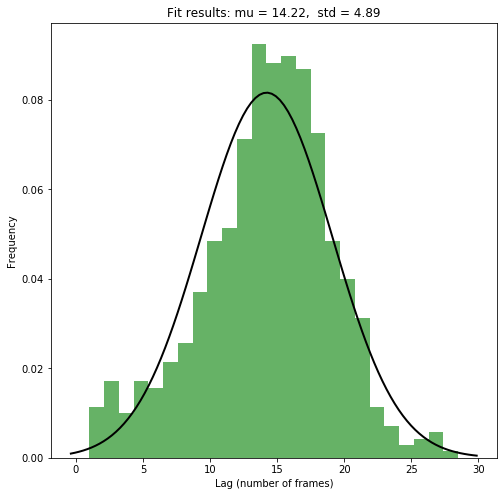

In [72]:
# Fit a normal distribution to the data
mu, std = norm.fit(allLags[allLags > 0])

plt.figure(figsize=(8,8))
plt.xlabel("Lag (number of frames)")
plt.ylabel("Frequency")
plt.hist(allLags, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)


# Distribution of how many stim each neuron is responsive toward

Text(0.5, 1.0, 'Fit results: mu = 9.82,  std = 5.38')

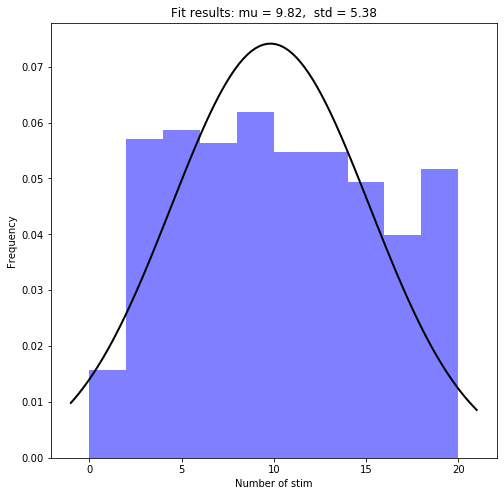

In [73]:
# Fit a normal distribution to the data
mu, std = norm.fit(stimCounts)

plt.figure(figsize=(8,8))
plt.xlabel("Number of stim")
plt.ylabel("Frequency")
plt.hist(stimCounts, bins=10, density=True, alpha=0.5, color='blue')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

# Trace for a "hyperactive" neuron; i.e. one that is responsive to all stim

[5, 83, 135, 160, 193, 253, 258, 259, 262, 266, 280, 314, 357, 360, 365, 371, 377, 402, 424, 426, 436, 439, 452]


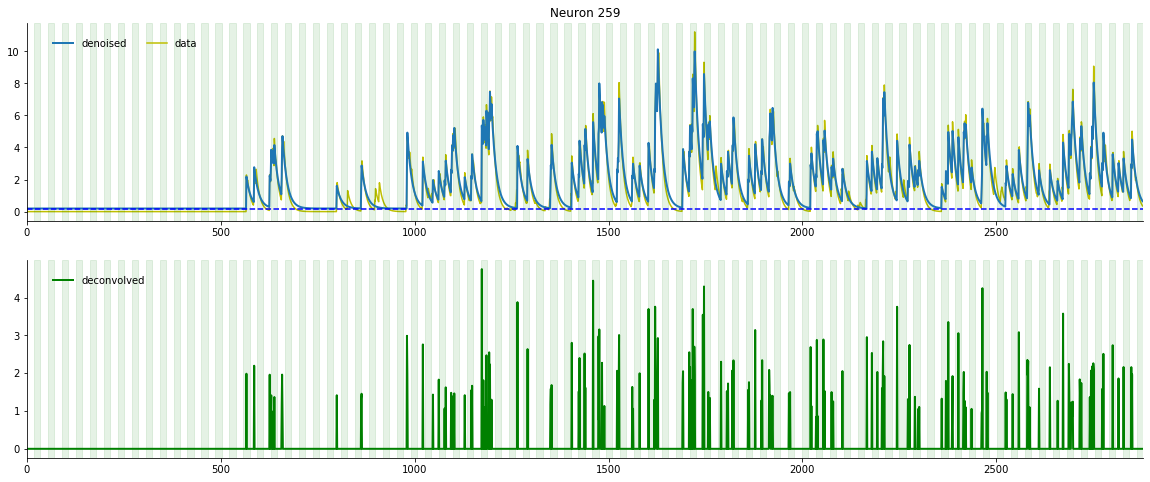

In [74]:
print(hyperNeurons)

# Let's just look at a random hyper neuron, because why not

n = np.random.randint(0,len(hyperNeurons))
plot_trace(hyperNeurons[n])



In [ ]:
# Distribution of length of time a neuron is active for a stim it is responsive toward

/Users/nicolemoiseyev/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


Text(0.5, 1.0, 'Fit results: mu = 4.28,  std = 2.65')

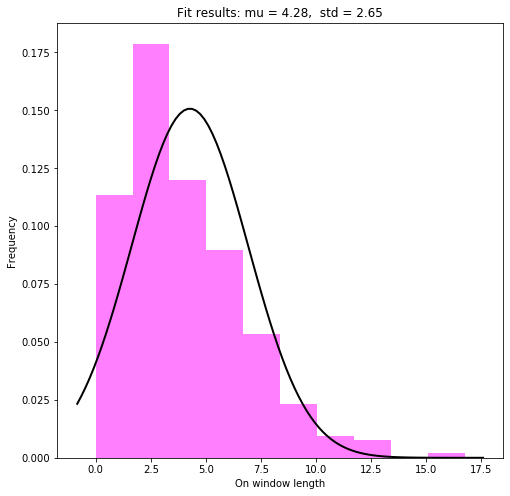

In [76]:
# Fit a normal distribution to the data
mu, std = norm.fit(allLengths[allLengths > 0])

plt.figure(figsize=(8,8))
plt.xlabel("On window length")
plt.ylabel("Frequency")
plt.hist(allLengths, bins=10, density=True, alpha=0.5, color='magenta')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)